In [1]:
from imutils import contours
import imutils
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
import cv2
import numpy as np
from skimage import feature
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import convolve2d,gaussian,correlate2d,find_peaks
from scipy.ndimage import sobel
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import scipy.stats as st
from matplotlib.pyplot import imshow
from skimage import measure
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from math import sqrt
import cProfile
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

In [2]:
class display():
    def __init__(self):
        self.width = 128
        self.height = 64
        self.number_of_pixels = self.width * self.height
        
display = display()

In [3]:
class image_utils():
    def importImageFromFile(filename):
        image = Image.open(filename)
        return image

    def crop_image(image, crop_coordinates):
        cropped_image = image.crop(crop_coordinates)
        return cropped_image

    def return_color_channel(image,channel):
        red, green, blue =  image.split()
        if(channel == "red"):
            return red
        elif(channel == "blue"):
            return blue
        elif(channel == "green"):
            return green
        else:
            print("Error, channel is not red green or blue")
            
    def np_array_to_pillow_image(nparray):
        image = Image.fromarray(nparray)
        return image
    
    def pillow_image_to_np_array(pillow_image):
        return np.array(pillow_image)

In [4]:
blue_image = cv2.imread('images/blue_image.png',0)


In [5]:
##### warp the image so that the four corners are in the corners of the image
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped


upleft= (599,326)
downleft = (632,595)
downright = (1154,542)
upright = (1129,272)
points = [upleft,downleft,upright,downright]
points = np.array(points)


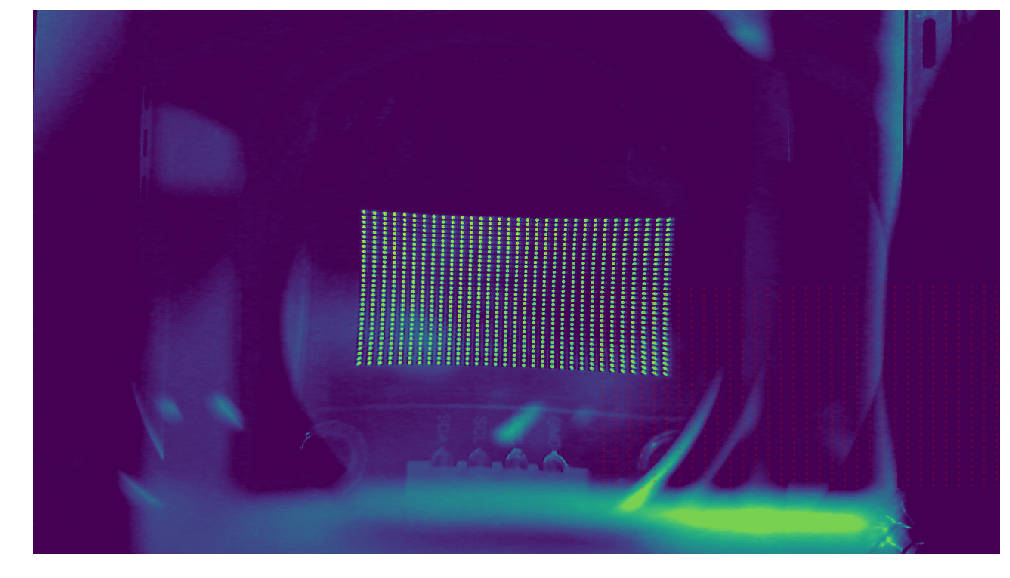

In [6]:
def generate_grid(top_left,bottom_left,top_right,bottom_right,dots_x=32,dots_y=32):
    dot_coordinates = np.zeros((dots_x,dots_y),dtype=object)
    for i in range(dots_x):
        for j in range(dots_y):
            p1 = top_left + i/(dots_x-1) * (top_right-top_left)
            p2 = bottom_left + i/(dots_x-1)  * (bottom_right-bottom_left)
            pt = p1 + j/(dots_y-1) * (p2-p1)
            dot_coordinates[i,j] = pt
    return dot_coordinates

top_left = np.array([753,370])
bottom_left = np.array([756,632])
bottom_right = np.array([1276,629])
top_right = np.array([1276,365])
        
grid = generate_grid(top_left=top_left,bottom_left=bottom_left,top_right=top_right,bottom_right=bottom_right)

fib, axes = plt.subplots(figsize=(20, 10))
plt.imshow(blue_image,interpolation='nearest')

for line in grid:
    for point in line:
        x,y = point
        c = plt.Circle((x, y), 0.1, color='red', linewidth=2, fill=False)
        axes.add_patch(c)
axes.set_axis_off()
plt.show()

In [7]:
#we want to match the components inside of the grid with their closest point_center
#Once matched we will find the value of the point_center within the image

def match_grid_to_point_centers(image,grid,point_centers):
    returnable = np.zeros(grid.shape)
    #itterate over the grid 
    for x in range(grid.shape[1]):
        for y in range(grid.shape[0]):
            #for each element within the grid we want to find the point_center with the lowest L2 norm
            subtracted = np.subtract(point_centers,grid[y,x])
            normed = np.linalg.norm(subtracted,axis=1)
            #find the minimum norm
            argmin = np.argmin(normed)
            #Find the center point which this minimum norm corresponds to
            center_point = point_centers[argmin]
            #Find the pixel value of this center_point
            pixel_value = image[int(center_point[1]),int(center_point[0])]
            returnable[y,x] = pixel_value
    return returnable

def get_binary_values_from_image_with_grid(image,grid):
    returnable = np.zeros(grid.shape)
    for x in range(grid.shape[1]):
        for y in range(grid.shape[0]):
            grid_coordinate = grid[y,x]
            pixel_value = image[int(grid_coordinate[1]),int(grid_coordinate[0])]
            if(pixel_value > 60):
                returnable[y,x] = 1
            else:
                returnable[y,x] = 0
    return returnable
    
binary_values = get_binary_values_from_image_with_grid(blue_image,grid)

# value_matrix = match_grid_to_point_centers(warped_image,grid,point_centers)

953


/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


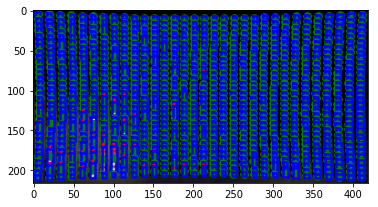

In [58]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import math

upleft= (433,263)
downleft = (426,473)
downright = (845,488)
upright = (849,272)
points = [upleft,downleft,upright,downright]
points = np.array(points)

blue_image_cropped = four_point_transform(blue_image,points)

#threshold to get binary_image

# apply threshold
thresh = threshold_otsu(blue_image_cropped)
bw = closing(blue_image_cropped > thresh, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)

regions = regionprops(label_image)

print(len(regions))

fig, ax = plt.subplots()
ax.imshow(blue_image_cropped, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()


#sort points into a grid
grid_binary = np.zeros((32,32))
from scipy.spatial import cKDTree 
data_for_tree = np.zeros((len(regions),2))
for index,value in enumerate(regions):
    y , x = value.centroid
    data_for_tree[index,0] = x
    data_for_tree[index,1] = y
   
tree = cKDTree(data_for_tree)

#find the top_left point
#find the bottom_left point
height,width = blue_image_cropped.shape
top_left_index, top_left_coordinate = tree.query([0,0],1)
top_left = data_for_tree[np.asarray(top_left_coordinate)]

bottom_left_index, bottom_left_coordinate = tree.query([0,height],1)
bottom_left = data_for_tree[np.asarray(bottom_left_coordinate)]

bottom_right_index, bottom_right_coordinate = tree.query([width,height],1)
bottom_right = data_for_tree[np.asarray(bottom_right_coordinate)]

top_right_index, top_right_coordinate = tree.query([width,0],1)
top_right = data_for_tree[np.asarray(top_right_coordinate)]
        
grid = generate_grid(top_left=top_left,bottom_left=bottom_left,top_right=top_right,bottom_right=bottom_right) 
largest_distance_to_point = 0
for y,row in enumerate(grid):
    for x, point in enumerate(row):
        dist,index = tree.query(point,1)
        #pass into image 
        image_value = blue_image_cropped[int(round(data_for_tree[index][1])),round(int(data_for_tree[index][0]))]
        if(image_value > 50):
            grid_binary[y,x] = 1
        else:
            grid_binary[y,x] = 0
        
        if(dist>largest_distance_to_point):
            largest_distance_to_point = dist
            

1024


/home/asludds/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


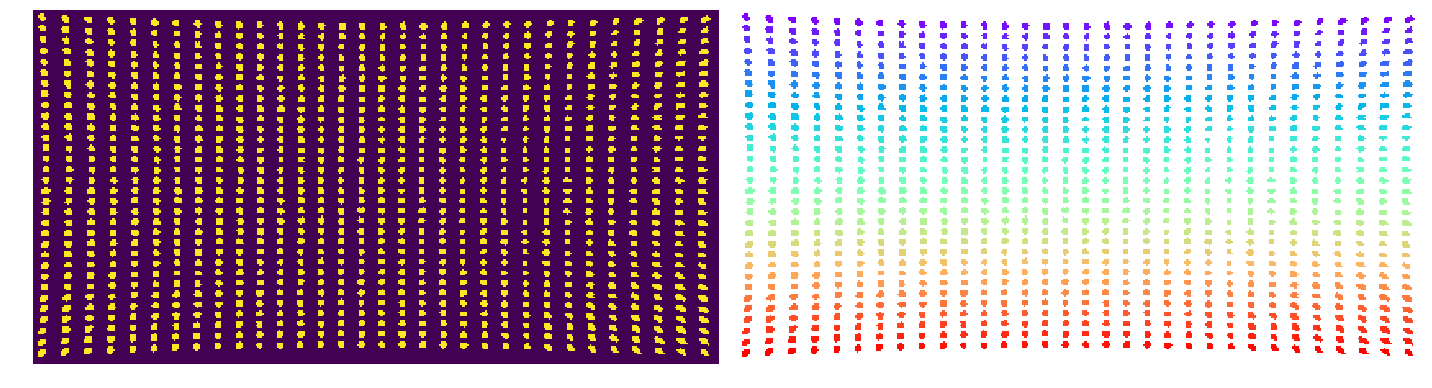

In [97]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy import ndimage
from skimage.filters import sobel

upleft= (433,263)
downleft = (426,473)
downright = (845,488)
upright = (849,272)
points = [upleft,downleft,upright,downright]
points = np.array(points)

blue_image_cropped = four_point_transform(blue_image,points)



thresh = 100

sobel_area = sobel(blue_image_cropped)

markers = np.zeros_like(blue_image_cropped)

#filter blue_image_cropped
blue_image_cropped_thresh_results = blue_image_cropped < thresh
blue_image_cropped[blue_image_cropped_thresh_results] = 0
# markers[blue_image_cropped_thresh_results] = 1

blue_image_cropped_thresh_results = blue_image_cropped >= thresh
blue_image_cropped[blue_image_cropped_thresh_results] = 255
# markers[blue_image_cropped_thresh_results] = 2

# use a boolean condition to find where pixel values are > 0.75
blobs = blue_image_cropped == 255

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs)

# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(blue_image_cropped, labels, np.arange(nlabels) + 1)).T

print(len(r))

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 20))
ax[0].imshow(blue_image_cropped)
ax[1].hold(True)
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
# for ri, ci, di in zip(r, c, d):
#     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
#                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
#     ax[1].annotate('d=%.1f' % di, xy=(ci, ri),  xytext=(0, -5),
#                    textcoords='offset points', ha='center', va='top',
#                    fontsize='x-large')
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()




# segmentation = watershed(sobel_area, markers)
# segmentation = ndi.binary_fill_holes(segmentation - 1)
    
# labeled_coins, _ = ndi.label(segmentation)   

# plt.imshow(labeled_coins)

# Comparison between image_max and im to find the coordinates of local maxima
# coordinates = peak_local_max(blue_image_cropped, min_distance=4, num_peaks = 1024)
# print(32*32)
# print(len(coordinates))

# display results
# fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
# ax = axes.ravel()
# ax[0].imshow(blue_image_cropped, cmap=plt.cm.gray)
# ax[0].axis('off')
# ax[0].set_title('Original')

# ax[1].imshow(blue_image_cropped, cmap=plt.cm.gray)
# ax[1].autoscale(False)
# ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[1].axis('off')
# ax[1].set_title('Peak local max')

# fig.tight_layout()

# plt.show()